In [19]:
# For part 1 (data collection and preprocessing)
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# For part 2 (undersampling via stratified SRS)
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import resample
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture

# For part 3 (classificaiton and prediction)
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
import seaborn as sns

In [32]:
def classification_and_evaluation(df, baseline=None):
    """
    Classify and evaluate a dataset with optional baseline resampling.
    """
    X = df.drop(columns=['y'])
    y = df['y']

    if baseline is None:
        # Directly split the already undersampled dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        print(f"Training Data shape (already undersampled): {X_train.shape}, {y_train.shape}")
        print(f"Testing Data shape (already undersampled): {X_test.shape}, {y_test.shape}")
    else:
        # Apply the specified undersampling technique to the entire dataset
        resampling_methods = {
            'R': RandomUnderSampler(random_state=42),
            'N': NearMiss(version=1),
            'T': TomekLinks(),
        }
        sampler = resampling_methods.get(baseline[0])
        if not sampler:
            print(f"Invalid baseline method: {baseline[0]}")
            return

        # Apply undersampling to the entire dataset
        X_resampled, y_resampled = sampler.fit_resample(X, y)

        # Train-test split on the undersampled dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42
        )
        print(f"Training Data shape after {baseline} undersampling: {X_train.shape}, {y_train.shape}")
        print(f"Training Data shape after {baseline} undersampling: {X_test.shape}, {y_test.shape}")

    # Train a RandomForestClassifier
    RF = RandomForestClassifier(random_state=42)
    RF.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = RF.predict(X_test)
    evaluate_model(y_test, y_pred)

In [36]:
def evaluate_model(y_true, y_pred):
    """
    Evaluates a classification model by printing the confusion matrix, 
    classification report, class-wise metrics, and plotting the AUC-ROC 
    and precision-recall curves.
    
    Parameters:
        y_true (array-like): Actual labels
        y_pred (array-like): Predicted probabilities or labels
    """
    # Ensure binary predictions or extract labels from probabilities
    y_pred_labels = (
        np.where(y_pred >= 0.5, 1, 0) if y_pred.ndim == 1 else np.argmax(y_pred, axis=1)
    )

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="coolwarm", 
        xticklabels=["Predicted No", "Predicted Yes"], 
        yticklabels=["Actual No", "Actual Yes"]
    )
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # 2. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_labels))

    # 3. Class-wise Performance Metrics
    report_dict = classification_report(y_true, y_pred_labels, output_dict=True)
    class_metrics = pd.DataFrame({
        metric: [report_dict[class_name][metric] for class_name in ["0", "1"]]
        for metric in ["precision", "recall", "f1-score"]
    }, index=["No", "Yes"])
    plt.figure(figsize=(8, 5))
    sns.heatmap(class_metrics, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Class-wise Performance Metrics")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.tight_layout()
    plt.show()

    # 4. AUC-ROC Curve (Binary Classification)
    if len(np.unique(y_true)) == 2:
        roc_auc = roc_auc_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure(figsize=(8, 5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], "k--", lw=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("AUC-ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    # 5. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    avg_precision = average_precision_score(y_true, y_pred)
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()


In [4]:
# NOTE: Only put one sampling function at a time
def sampling(df):
    """
    Undersample through maximizing mutual information: (3 parameters 12 VARIANTS)

    parameter 1: num_strata_fixed; is the number of strata fixed or not (2 values: True/ False)
    parameter 2: use_features; either use the data's features or mutual information to determine the number of strata IF num_strata_fixed is true (2 values: True/False)
    parameter 3: allocation; the allocation type use to sample data from each stratum (3 values: 'Neyman', 'Optimal', None)
    """

    # Alex 
    output=sampling_through_mutual_information(df, num_strata_fixed=False, use_features=False, allocation="Neyman")

    return output

In [45]:
# Create a pairwise MI matrix
from sklearn.metrics import mutual_info_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from joblib import Parallel, delayed

# import numpy as np
def sampling_through_mutual_information(df, num_strata_fixed, use_features, allocation, max_clusters=10):
    """
    Perform stratified undersampling with optional dynamic determination of the number of strata.

    :param df: DataFrame with features and target 'y'.
    :param num_strata_fixed: Boolean indicating whether the number of strata is fixed.
    :param use_features: Flag to decide whether to use all features or mutual information for clustering.
    :param allocation: Allocation type for undersampling (e.g., 'Neyman', 'Optimal', None).
    :param max_clusters: Maximum number of clusters to test when finding optimal strata.
    :return: Balanced DataFrame with undersampled majority class.
    """
    

    # Step 1: Filter majority class samples
    majority_class = df[df['y'] == 0].copy()

    # Step 2: Compute pairwise MI efficiently
    X_majority = majority_class.drop(columns=['y']).values  # Features of majority class
    N = len(X_majority)

    #---------------------------------------------------
    # OLD STEP 2
    # Define a function for computing entropy of a row
    # def compute_entropy(row):
    #     # Calculate the entropy of a row (sample)
    #     unique, counts = np.unique(row, return_counts=True)
    #     probabilities = counts / len(row)
    #     return -np.sum(probabilities * np.log2(probabilities))

    # # Define a function for computing MI for a single row pair and normalizing by entropy
    # def compute_mi_row(i, X):
    #     row_mi = []
    #     entropy_i = compute_entropy(X[i])
    #     for j in range(i, N):
    #         entropy_j = compute_entropy(X[j])
    #         mi = mutual_info_score(X[i], X[j])
    #         # Normalize MI by the minimum entropy of the two rows
    #         mi_normalized = mi / min(entropy_i, entropy_j)
    #         row_mi.append(mi_normalized)
    #     return row_mi

    # # Use joblib.Parallel to compute MI for each row in parallel
    # results = Parallel(n_jobs=2)(delayed(compute_mi_row)(i, X_majority) for i in range(N))

    # # Convert results into a symmetric matrix
    # mi_matrix = np.zeros((N, N))
    # for i, row in enumerate(results):
    #     mi_matrix[i, i:] = row
    #     mi_matrix[i:, i] = row  # Fill lower triangle

    # print(mi_matrix)
    # OLD STEP 2
    #---------------------------------------------------


    # NEW STEP 2
    #---------------------------------------------------

    # Define a function to compute entropy of a row
    def compute_entropy(row):
        """Calculate the entropy of a row (sample)."""
        _, counts = np.unique(row, return_counts=True)
        probabilities = counts / len(row)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Avoid log(0)

    # Define a function to compute MI for a single row pair and normalize by entropy
    def compute_mi_row(i, X, entropies):
        """Compute the normalized mutual information for row i with all subsequent rows."""
        row_mi = []
        for j in range(i, X.shape[0]):
            mi = mutual_info_score(X[i], X[j])
            # Normalize MI by the minimum entropy of the two rows
            mi_normalized = mi / min(entropies[i], entropies[j])
            row_mi.append(mi_normalized)
        return row_mi

    # Optimized main computation block
    def compute_mi_matrix(X, n_jobs=2):
        """
        Compute the mutual information matrix for X with normalization by entropy.
        
        Parameters:
            X (ndarray): Input data (rows are samples, columns are features).
            n_jobs (int): Number of parallel jobs for computation.
        
        Returns:
            ndarray: Symmetric mutual information matrix.
        """
        N = X.shape[0]
        # Precompute entropies for all rows
        entropies = Parallel(n_jobs=n_jobs)(delayed(compute_entropy)(X[i]) for i in range(N))
        
        # Compute MI rows in parallel
        results = Parallel(n_jobs=n_jobs)(delayed(compute_mi_row)(i, X, entropies) for i in range(N))
        
        # Convert results into a symmetric matrix
        mi_matrix = np.zeros((N, N))
        for i, row in enumerate(results):
            mi_matrix[i, i:] = row
            mi_matrix[i:, i] = row  # Fill lower triangle
        return mi_matrix

    mi_matrix = compute_mi_matrix(X_majority, n_jobs=4)
    print(mi_matrix)

    # NEW STEP 2
    #---------------------------------------------------
    


    print("STEP 3:")
    # Step 3: Determine the number of strata (infer from elbow method or SIlhoutette score)
    # Now call the function with your MI matrix
    # MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
    within_cluster_dissimilarity = elbow_method_for_clusters(mi_matrix)

    # Now call the function with your MI matrix
    # MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
    silhouette_scores = silhouette_method_for_clusters(mi_matrix)

    # Optionally, print the dissimilarity values for each number of clusters
    for n_clusters, dissim in zip(range(2, 11), within_cluster_dissimilarity):
        print(f"{n_clusters} clusters: {dissim}")

    # ----------------

    best_silhouette_scores=0
    optimal_num_strata=1

    # Optionally, print the silhouette scores for each number of clusters
    for n_clusters, score in zip(range(2, 11), silhouette_scores):
        print(f"{n_clusters} clusters: {score}")
        if score >= best_silhouette_scores:
            best_silhouette_scores=score
            optimal_num_strata=n_clusters

    # Regardless NOW
    # optimal_num_strata = 4
    # print("BEST NUMBER OF STRATA: ", optimal_num_strata)

    # (NEW-PROTO) Step 4: Compare Clustering Methods and Select the Best
    models = {
        "KMeans": KMeans(n_clusters=optimal_num_strata, random_state=42, ),
        "Agglomerative": AgglomerativeClustering(n_clusters=optimal_num_strata),
        "Spectral": SpectralClustering(n_clusters=optimal_num_strata, random_state=42, affinity="precomputed"),
        "GMM": GaussianMixture(n_components=optimal_num_strata, random_state=42),
    }

    results = {}
    for name, model in models.items():
        if name == "Spectral":
            clusters = model.fit_predict(mi_matrix)  # Spectral uses precomputed affinity matrix
        else:
            clusters = model.fit_predict(mi_matrix)
        # Compute all metrics
        silhouette = silhouette_score(mi_matrix, clusters)
        db_index = davies_bouldin_score(mi_matrix, clusters)
        ch_index = calinski_harabasz_score(mi_matrix, clusters)
        results[name] = {
            "Silhouette Score": silhouette,
            "Davies-Bouldin": db_index,
            "Calinski-Harabasz": ch_index,
        }

    # Rank the clustering methods
    ranking = {metric: [] for metric in ["Silhouette Score", "Davies-Bouldin", "Calinski-Harabasz"]}
    for metric in ranking:
        if metric == "Davies-Bouldin":  # Lower is better for Davies-Bouldin
            sorted_methods = sorted(results.items(), key=lambda x: x[1][metric])
        else:  # Higher is better for other metrics
            sorted_methods = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        ranking[metric] = [method for method, _ in sorted_methods]

    # Aggregate rankings
    final_scores = {method: 0 for method in results}
    for metric, ranked_methods in ranking.items():
        for rank, method in enumerate(ranked_methods):
            final_scores[method] += rank

    # Select the best method
    best_method = min(final_scores, key=final_scores.get)

    # Display Results
    print("\nClustering Method Comparison:")
    for method, scores in results.items():
        print(f"\nMethod: {method}")
        for metric, score in scores.items():
            print(f"  {metric}: {score:.3f}")

    print("\nRanking by Metrics:")
    for metric, ranked_methods in ranking.items():
        print(f"\nMetric: {metric}")
        print("  " + " > ".join(ranked_methods))

    print("\nOverall Ranking:")
    for method, score in sorted(final_scores.items(), key=lambda x: x[1]):
        print(f"{method}: Rank {score + 1}")

    print(f"\nBest Clustering Method: {best_method}")

    
    # Step 4 (CONTINUED): Group majority class samples into strata using clustering on MI matrix (HERE)

    # "KMeans", "Agglomerative","Spectral", "GMM"

    if best_method=="KMeans":
        # K-means clustering (75.75...)
        print("Chose KMEANS!")
        distance_matrix = 1 - mi_matrix
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        X_mds = mds.fit_transform(distance_matrix)
        kmeans = KMeans(n_clusters=optimal_num_strata, random_state=42)
        majority_class['stratum'] = kmeans.fit_predict(X_mds)

    elif best_method=="Agglomerative":
        print("Chose Linkage!")
        # hierarchial clustering (POOR)
        clustering = AgglomerativeClustering(n_clusters=optimal_num_strata, metric='precomputed', linkage='average')
        majority_class['stratum'] = clustering.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

    elif best_method=="Spectral":
        print("Chose Spectral!")
        # Spectral clustering (SLIGHTLY BETTER)
        spectral = SpectralClustering(n_clusters=optimal_num_strata, affinity='precomputed', random_state=42)
        # majority_class['stratum'] = spectral.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity
        majority_class['stratum'] = spectral.fit_predict(mi_matrix)  # Convert similarity to dissimilarity

    elif best_method=="GMM":
        print("Chose GMM!")
        distance_matrix = 1 - mi_matrix
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        X_mds = mds.fit_transform(distance_matrix)
        gmm = GaussianMixture(n_components=optimal_num_strata, random_state=42)
        majority_class['stratum'] = gmm.fit_predict(X_mds)

    print(majority_class['stratum'].value_counts())
    
    

    # Step 5: Perform undersampling on majority class samples

    # Group majority class by stratum
    strata_groups = majority_class.groupby('stratum')
    minority_class_size = len(df[df['y'] == 1])
    allocation='Neyman'
    # Select allocation method
    if allocation == 'Equal':
        sampled_majority_class = equal_allocation(majority_class, strata_groups, minority_class_size)
    elif allocation == 'Neyman':
        sampled_majority_class = neyman_allocation(majority_class, strata_groups, minority_class_size)
    elif allocation == 'Optimal':
        sampled_majority_class = optimal_allocation(majority_class, strata_groups, minority_class_size)

    # Step 5.5: verify undersampled data majority with regular majoirty data
    # print(sampled_majority_class)
    compare_datasets(majority_class, sampled_majority_class)
    

    # Step 6: Combine undersampled majority class with the minority class
    minority_class = df[df['y'] == 1]  # Keep all minority class samples
    final_df = pd.concat([sampled_majority_class, minority_class])

    # Shuffle the resulting dataset
    final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Drop unneeded columns
    final_df.drop(columns=['stratum'], inplace=True)

    print(final_df['y'].value_counts())

    return final_df

In [6]:
# Equal Allocation
def equal_allocation(majority_class, strata_groups, minority_class_size):

    # Initial Equal Allocation: Sample the same number of samples from each stratum
    samples_per_stratum = minority_class_size // len(strata_groups)
    remaining_samples = minority_class_size - (samples_per_stratum * len(strata_groups))

    sampled_strata = []

    # Perform initial SRS on each stratum with equal allocation
    for stratum, group in strata_groups:
        num_samples_to_sample = min(samples_per_stratum, len(group))  # Ensure we don't sample more than available
        sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
        sampled_strata.append(sampled_group)

    # Keep track of the number of samples we have so far
    sampled_majority_class = pd.concat(sampled_strata, axis=0)

    remaining_samples_needed = minority_class_size - len(sampled_majority_class)

    # If there are remaining samples to be drawn, perform SRS again
    while remaining_samples_needed > 0:
        print(f"Remaining samples needed: {remaining_samples_needed}")

        # Find strata that still have samples left to be drawn
        remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]

        # Sample from these remaining strata using SRS
        strata_groups_remaining = remaining_strata.groupby('stratum')

        for stratum, group in strata_groups_remaining:
            # If there are still remaining samples in this stratum, sample them
            num_samples_to_sample = min(len(group), remaining_samples_needed)
            sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
            sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
            
            # Reduce remaining samples needed
            remaining_samples_needed -= num_samples_to_sample
            
            # Exit early if no more samples are needed
            if remaining_samples_needed <= 0:
                break
    
    return sampled_majority_class


In [168]:
# # Neyman Allocation (OG)
# def neyman_allocation(majority_class, strata_groups, minority_class_size):
#     # Calculate strata sizes (N_h) and variances (S_h)
#     strata_info = strata_groups.size().to_frame(name='N_h')
#     strata_info['S_h'] = strata_groups.std().mean(axis=1)  # Standard deviation across features

#     # Compute weights for Neyman allocation
#     strata_info['weight'] = strata_info['N_h'] * strata_info['S_h']

#     # Normalize weights to calculate samples per stratum
#     strata_info['n_h'] = (strata_info['weight'] / strata_info['weight'].sum()) * minority_class_size
#     strata_info['n_h'] = strata_info['n_h'].round().astype(int)  # Round to nearest integer

#     # Sample from each stratum based on calculated n_h
#     sampled_strata = []
#     for stratum, group in strata_groups:
#         num_samples_to_sample = min(strata_info.loc[stratum, 'n_h'], len(group))  # Ensure we don't oversample
#         sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
#         sampled_strata.append(sampled_group)

#     # Combine all sampled strata
#     sampled_majority_class = pd.concat(sampled_strata, axis=0)

#     # Handle remaining samples (if minority_class_size isn't met due to rounding or small strata)
#     remaining_samples_needed = minority_class_size - len(sampled_majority_class)
#     if remaining_samples_needed > 0:
#         remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]
#         strata_groups_remaining = remaining_strata.groupby('stratum')
#         for stratum, group in strata_groups_remaining:
#             num_samples_to_sample = min(len(group), remaining_samples_needed)
#             sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
#             sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
#             remaining_samples_needed -= num_samples_to_sample
#             if remaining_samples_needed <= 0:
#                 break

#     return sampled_majority_class


In [164]:
# # Neyman (currently working ok)
# def neyman_allocation(majority_class, strata_groups, minority_class_size):
#     # Calculate strata sizes (N_h) and variances (S_h)
#     strata_info = strata_groups.size().to_frame(name='N_h')
#     strata_info['S_h'] = strata_groups.std().mean(axis=1)  # Standard deviation across features

#     # Compute weights for Neyman allocation
#     strata_info['weight'] = strata_info['N_h'] * strata_info['S_h']

#     # Normalize weights to calculate samples per stratum
#     strata_info['n_h'] = (strata_info['weight'] / strata_info['weight'].sum()) * minority_class_size
#     strata_info['n_h'] = strata_info['n_h'].round().astype(int)  # Round to nearest integer

#     # Initialize sampled data and remaining samples needed
#     sampled_strata = []
#     remaining_samples_needed = minority_class_size

#     # Create a dictionary to track available samples per stratum
#     strata_samples = {stratum: group for stratum, group in strata_groups}

#     # Sample iteratively until the desired size is reached
#     while remaining_samples_needed > 0:
#         for stratum, group in strata_samples.items():
#             if remaining_samples_needed <= 0:
#                 break

#             # Determine the number of samples to draw
#             num_samples_to_sample = min(strata_info.loc[stratum, 'n_h'], len(group), remaining_samples_needed)

#             # Sample from the stratum
#             sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
#             sampled_strata.append(sampled_group)

#             # Update the remaining samples and adjust available group
#             remaining_samples_needed -= num_samples_to_sample
#             strata_samples[stratum] = group.drop(sampled_group.index)

#         # Recalculate `n_h` for remaining samples proportionally if needed
#         if remaining_samples_needed > 0:
#             remaining_weights = {stratum: strata_info.loc[stratum, 'weight'] for stratum in strata_samples if len(strata_samples[stratum]) > 0}
#             total_weight = sum(remaining_weights.values())
#             for stratum in remaining_weights:
#                 strata_info.loc[stratum, 'n_h'] = (remaining_weights[stratum] / total_weight) * remaining_samples_needed
#                 strata_info.loc[stratum, 'n_h'] = strata_info.loc[stratum, 'n_h'].round().astype(int)

#     # Combine all sampled data
#     sampled_majority_class = pd.concat(sampled_strata, axis=0)

#     return sampled_majority_class


In [7]:
# Neyman allocation (Prototype)

def neyman_allocation(majority_class, strata_groups, minority_class_size):
    # Calculate strata sizes (N_h) and variances (S_h)
    strata_info = strata_groups.size().to_frame(name='N_h')
    strata_info['S_h'] = strata_groups.std().mean(axis=1)  # Standard deviation across features

    # Compute weights for Neyman allocation
    strata_info['weight'] = strata_info['N_h'] * strata_info['S_h']

    # Normalize weights to calculate samples per stratum
    strata_info['n_h'] = (strata_info['weight'] / strata_info['weight'].sum()) * minority_class_size
    strata_info['n_h'] = strata_info['n_h'].round().astype(int)  # Round to nearest integer

    # Sample from each stratum based on calculated n_h
    sampled_strata = []
    for stratum, group in strata_groups:
        num_samples_to_sample = min(strata_info.loc[stratum, 'n_h'], len(group))  # Ensure no oversampling
        sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
        sampled_strata.append(sampled_group)

    # Combine all sampled strata
    sampled_majority_class = pd.concat(sampled_strata, axis=0)

    # Handle remaining samples (if minority_class_size isn't met)
    remaining_samples_needed = minority_class_size - len(sampled_majority_class)
    if remaining_samples_needed > 0:
        # Filter out exhausted strata
        remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]
        strata_groups_remaining = remaining_strata.groupby('stratum')
        
        # Recalculate weights for remaining strata
        remaining_strata_info = strata_info.loc[remaining_strata['stratum'].unique()]
        remaining_strata_info['weight'] = remaining_strata_info['N_h'] * remaining_strata_info['S_h']
        remaining_strata_info['n_h'] = (remaining_strata_info['weight'] / remaining_strata_info['weight'].sum()) * remaining_samples_needed
        remaining_strata_info['n_h'] = remaining_strata_info['n_h'].round().astype(int)

        for stratum, group in strata_groups_remaining:
            num_samples_to_sample = min(remaining_strata_info.loc[stratum, 'n_h'], len(group))
            sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
            sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
            remaining_samples_needed -= num_samples_to_sample
            if remaining_samples_needed <= 0:
                break

    return sampled_majority_class


In [8]:
# Optimal Allocation
def optimal_allocation(majority_class, strata_groups, minority_class_size, costs=None):
    # Calculate strata sizes (N_h) and variances (S_h)
    strata_info = strata_groups.size().to_frame(name='N_h')
    strata_info['S_h'] = strata_groups.std().mean(axis=1)  # Standard deviation across features

    factor=5

    # Define non-uniform cost (penalize larger strata)
    strata_info = strata_info.sort_values(by='N_h')
    strata_info['C_h'] = factor ** (strata_info.index.to_series().rank() - 1)  # Costs: 1, 10, 100, ...


    # Compute weights for Optimal allocation
    strata_info['weight'] = strata_info['N_h'] * strata_info['S_h'] / strata_info['C_h']

    # Normalize weights to calculate samples per stratum
    strata_info['n_h'] = (strata_info['weight'] / strata_info['weight'].sum()) * minority_class_size
    strata_info['n_h'] = strata_info['n_h'].round().astype(int)  # Round to nearest integer

    # Sample from each stratum based on calculated n_h
    sampled_strata = []
    for stratum, group in strata_groups:
        num_samples_to_sample = min(strata_info.loc[stratum, 'n_h'], len(group))  # Ensure we don't oversample
        sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
        sampled_strata.append(sampled_group)

    # Combine all sampled strata
    sampled_majority_class = pd.concat(sampled_strata, axis=0)

    # Handle remaining samples (if minority_class_size isn't met due to rounding or small strata)
    remaining_samples_needed = minority_class_size - len(sampled_majority_class)
    # Special treatment on small strata
    if remaining_samples_needed > 0:
        remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]
        strata_groups_remaining = remaining_strata.groupby('stratum')
        for stratum, group in strata_groups_remaining:
            num_samples_to_sample = min(len(group), remaining_samples_needed)
            sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
            sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
            remaining_samples_needed -= num_samples_to_sample
            if remaining_samples_needed <= 0:
                break

    # regular treatment (proportional allocation)
    # if remaining_samples_needed > 0:
    #     # Calculate proportional weights for remaining strata
    #     remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]
    #     strata_groups_remaining = remaining_strata.groupby('stratum')
    #     strata_info_remaining = strata_info.loc[remaining_strata['stratum'].unique()]
        
    #     weights = strata_info_remaining['N_h'] / strata_info_remaining['N_h'].sum()
    #     strata_info_remaining['remaining_n_h'] = (weights * remaining_samples_needed).round().astype(int)

    #     for stratum, group in strata_groups_remaining:
    #         num_samples_to_sample = min(strata_info_remaining.loc[stratum, 'remaining_n_h'], len(group))
    #         sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
    #         sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
    #         remaining_samples_needed -= num_samples_to_sample
    #         if remaining_samples_needed <= 0:
    #             break

    return sampled_majority_class


In [137]:
# def optimal_allocation_optimized(majority_class, strata_groups, minority_class_size):

#     factor=5
    
#     # Calculate strata sizes (N_h) and variances (S_h)
#     strata_info = strata_groups.size().to_frame(name='N_h')
#     strata_info['S_h'] = strata_groups.std().mean(axis=1)  # Standard deviation across features
    
#     # Assign non-uniform costs (C_h)
#     strata_info = strata_info.sort_values(by='N_h')
#     strata_info['C_h'] = factor ** (strata_info.index.to_series().rank() - 1)

#     # Compute weights for optimal allocation
#     strata_info['weight'] = strata_info['N_h'] * strata_info['S_h'] / strata_info['C_h']
#     strata_info['n_h'] = (strata_info['weight'] / strata_info['weight'].sum() * minority_class_size).round().astype(int)

#     #---
#     # Calculate strata sizes (N_h) and variances (S_h)
#     strata_info = strata_groups.size().to_frame(name='N_h')
#     strata_info['S_h'] = strata_groups.std().mean(axis=1)  # Standard deviation across features

#     # Compute weights for Neyman allocation
#     strata_info['weight'] = strata_info['N_h'] * strata_info['S_h']

#     # Normalize weights to calculate samples per stratum
#     strata_info['n_h'] = (strata_info['weight'] / strata_info['weight'].sum()) * minority_class_size
#     strata_info['n_h'] = strata_info['n_h'].round().astype(int)  # Round to nearest integer
#     #---

#     # Initialize empty DataFrame for the sampled data
#     sampled_majority_class = pd.DataFrame()
#     remaining_samples_needed = minority_class_size

#     while remaining_samples_needed > 0:
#         sampled_strata = []
#         for stratum, group in strata_groups:
#             # Determine the number of samples to draw from this stratum
#             num_samples_to_sample = min(strata_info.loc[stratum, 'n_h'], len(group), remaining_samples_needed)
#             if num_samples_to_sample > 0:
#                 sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
#                 sampled_strata.append(sampled_group)

#                 # Decrease the remaining samples needed
#                 remaining_samples_needed -= num_samples_to_sample

#             # Exit the loop early if no more samples are needed
#             if remaining_samples_needed <= 0:
#                 break
        
#         # Combine sampled strata into the main DataFrame
#         if sampled_strata:
#             sampled_majority_class = pd.concat([sampled_majority_class] + sampled_strata, axis=0)

#     return sampled_majority_class


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

def elbow_method_for_clusters(MI_matrix, max_clusters=20):

    # Convert MI matrix to a dissimilarity matrix by doing 1 - MI matrix
    dissimilarity_matrix = 1 - MI_matrix

    # Step 1: Compute hierarchical clustering using the dissimilarity matrix
    # Perform hierarchical clustering (Ward's method is a good choice for minimizing variance)
    Z = linkage(dissimilarity_matrix, method='ward')

    # Step 2: Compute within-cluster dissimilarity for different cluster numbers
    within_cluster_dissimilarity = []

    for n_clusters in range(2, max_clusters + 1):
        # Cut the hierarchical tree to form 'n_clusters' clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')
        
        # Step 3: Compute the within-cluster dissimilarity (sum of pairwise distances within each cluster)
        dissimilarity = 0
        for cluster in set(clusters):
            cluster_indices = np.where(clusters == cluster)[0]
            cluster_points = dissimilarity_matrix[cluster_indices, :][:, cluster_indices]  # Submatrix of points in the same cluster
            dissimilarity += np.sum(pdist(cluster_points))  # Pairwise distance within cluster
        
        # Step 4: Store the within-cluster dissimilarity for the current number of clusters
        within_cluster_dissimilarity.append(dissimilarity)

    # Step 5: Plot the dissimilarity vs. number of clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), within_cluster_dissimilarity, marker='o')
    plt.xlabel('Number of clusters')
    plt.xticks(np.arange(0, max_clusters+1, step=2))
    plt.ylabel('Within-cluster dissimilarity')
    plt.title('Elbow Method for Hierarchical Clustering')
    plt.grid(True)
    plt.show()

    # Return the dissimilarity values for each number of clusters
    return within_cluster_dissimilarity

# # Now call the function with your MI matrix
# # MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
# within_cluster_dissimilarity = elbow_method_for_clusters(MI_matrix)

# # Optionally, print the dissimilarity values for each number of clusters
# for n_clusters, dissim in zip(range(2, 11), within_cluster_dissimilarity):
#     print(f"{n_clusters} clusters: {dissim}")


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

def silhouette_method_for_clusters(MI_matrix, max_clusters=20):
    # Convert MI matrix to a dissimilarity matrix by doing its complement
    dissimilarity_matrix = 1 - MI_matrix

    # Step 1: Compute hierarchical clustering using the dissimilarity matrix
    # Perform hierarchical clustering (Ward's method is a good choice for minimizing variance)
    Z = linkage(dissimilarity_matrix, method='ward')

    # Step 2: Store silhouette scores for different cluster numbers
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        # Cut the hierarchical tree to form 'n_clusters' clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Step 3: Calculate the silhouette score for the current number of clusters
        # Use the silhouette_score function to calculate the silhouette score for clustering
        score = silhouette_score(dissimilarity_matrix, clusters, metric='euclidean')
        
        # Step 4: Store the silhouette score for the current number of clusters
        silhouette_scores.append(score)

    # Step 5: Plot the silhouette score vs. number of clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xticks(np.arange(0, max_clusters+1, step=2))
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Hierarchical Clustering')
    plt.grid(True)
    plt.show()

    # Return the silhouette scores for each number of clusters
    return silhouette_scores

# Now call the function with your MI matrix
# MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
# silhouette_scores = silhouette_method_for_clusters(MI_matrix)

# Optionally, print the silhouette scores for each number of clusters
# for n_clusters, score in zip(range(2, 11), silhouette_scores):
#     print(f"{n_clusters} clusters: {score}")


In [11]:
def compare_datasets(original, undersampled):
    """
    Compare original and undersampled datasets with separate feature-wise mean and standard deviation analysis.

    Parameters:
        original (pd.DataFrame): Original dataset.
        undersampled (pd.DataFrame): Undersampled dataset.
    """
    # Step 1: Compute Feature-Wise Mean and Standard Deviation
    numerical_cols = original.select_dtypes(include=np.number).columns

    mean_original = original[numerical_cols].mean()
    mean_undersampled = undersampled[numerical_cols].mean()

    std_original = original[numerical_cols].std()
    std_undersampled = undersampled[numerical_cols].std()

    stats_comparison = pd.DataFrame({
        "Original Mean": mean_original,
        "Undersampled Mean": mean_undersampled,
        "Original Std": std_original,
        "Undersampled Std": std_undersampled
    })

    print("=== Feature-Wise Mean and Standard Deviation ===")
    print(stats_comparison)

    # Step 2: Plot Feature-Wise Mean
    plt.figure(figsize=(12, 6))
    x = np.arange(len(numerical_cols))

    plt.scatter(x, mean_original, label="Original Mean", color="blue", marker="o")
    plt.scatter(x, mean_undersampled, label="Undersampled Mean", color="orange", marker="o")

    # Customize plot for mean
    plt.title("Feature-Wise Mean Comparison")
    plt.xlabel("Features")
    plt.ylabel("Mean Value")
    plt.xticks(ticks=x, labels=numerical_cols, rotation=45, ha="right")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Step 3: Plot Feature-Wise Standard Deviation
    plt.figure(figsize=(12, 6))

    plt.scatter(x, std_original, label="Original Std", color="green", marker="x")
    plt.scatter(x, std_undersampled, label="Undersampled Std", color="red", marker="x")

    # Customize plot for standard deviation
    plt.title("Feature-Wise Standard Deviation Comparison")
    plt.xlabel("Features")
    plt.ylabel("Standard Deviation Value")
    plt.xticks(ticks=x, labels=numerical_cols, rotation=45, ha="right")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# Experiment

In [40]:
data_path="https://raw.githubusercontent.com/Alex-Mak-MCW/Data_Sampling_Project/refs/heads/main/processed_breast_cancer_data.csv"


# data_path="https://raw.githubusercontent.com/Alex-Mak-MCW/Data_Sampling_Project/refs/heads/main/Processed_Input.csv"


data=pd.read_csv(data_path)


In [ ]:
# # or read Shubham's xls file
# # import xlrd
# data2=pd.read_csv("/Users/alexmak/Desktop/CMPUT/School/Year_6/STAT_561/Project/X_majority_subset.csv")

In [206]:
# data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5000 non-null   float64
 1   1       5000 non-null   float64
 2   2       5000 non-null   float64
 3   3       5000 non-null   float64
 4   4       5000 non-null   float64
 5   5       5000 non-null   float64
 6   6       5000 non-null   float64
 7   7       5000 non-null   float64
 8   8       5000 non-null   float64
 9   9       5000 non-null   float64
 10  10      5000 non-null   float64
 11  11      5000 non-null   float64
 12  12      5000 non-null   float64
 13  13      5000 non-null   float64
 14  14      5000 non-null   float64
 15  15      5000 non-null   float64
 16  16      5000 non-null   float64
 17  17      5000 non-null   float64
 18  18      5000 non-null   float64
 19  19      5000 non-null   float64
 20  20      5000 non-null   float64
 21  21      5000 non-null   float64
 22  

In [11]:
# data['poutcome']=data['poutcome']*2

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    272 non-null    int64
 1   menopause              272 non-null    int64
 2   tumor-size             272 non-null    int64
 3   inv-nodes              272 non-null    int64
 4   node-caps              272 non-null    int64
 5   deg-malig              272 non-null    int64
 6   irradiat               272 non-null    int64
 7   y                      272 non-null    int64
 8   breast_left            272 non-null    int64
 9   breast_right           272 non-null    int64
 10  breast-quad_central    272 non-null    int64
 11  breast-quad_left_low   272 non-null    int64
 12  breast-quad_left_up    272 non-null    int64
 13  breast-quad_right_low  272 non-null    int64
 14  breast-quad_right_up   272 non-null    int64
dtypes: int64(15)
memory usage: 32.0 KB


In [42]:
data

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,irradiat,y,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,2,2,6,0,0,3,0,0,1,0,0,1,0,0,0
1,3,2,4,0,0,2,0,0,0,1,0,0,0,0,1
2,3,2,4,0,0,2,0,0,1,0,0,1,0,0,0
3,5,1,3,0,0,2,0,0,0,1,0,0,1,0,0
4,3,2,0,0,0,2,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2,2,6,0,0,2,0,1,1,0,0,0,1,0,0
268,2,2,4,0,0,3,1,1,1,0,0,0,1,0,0
269,5,1,4,0,0,1,0,1,0,1,0,0,1,0,0
270,3,1,6,1,0,3,0,1,1,0,0,1,0,0,0


[[0.69314718 0.46056675 0.63835937 ... 0.39852879 0.63667457 0.43650672]
 [0.46056675 0.69314718 0.51535456 ... 0.44333076 0.45341458 0.43650672]
 [0.63835937 0.51535456 0.69314718 ... 0.39852879 0.63667457 0.43650672]
 ...
 [0.39852879 0.44333076 0.39852879 ... 0.69314718 0.38946887 0.4128086 ]
 [0.63667457 0.45341458 0.63667457 ... 0.38946887 0.69314718 0.41330084]
 [0.43650672 0.43650672 0.43650672 ... 0.4128086  0.41330084 0.69314718]]
STEP 3:


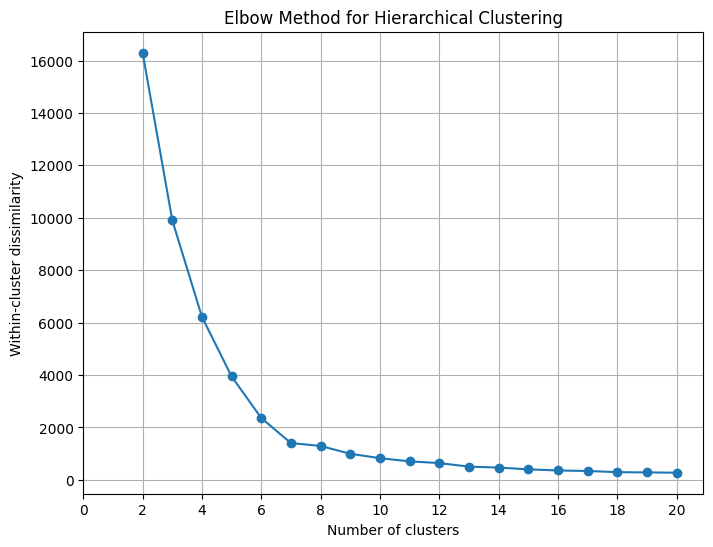

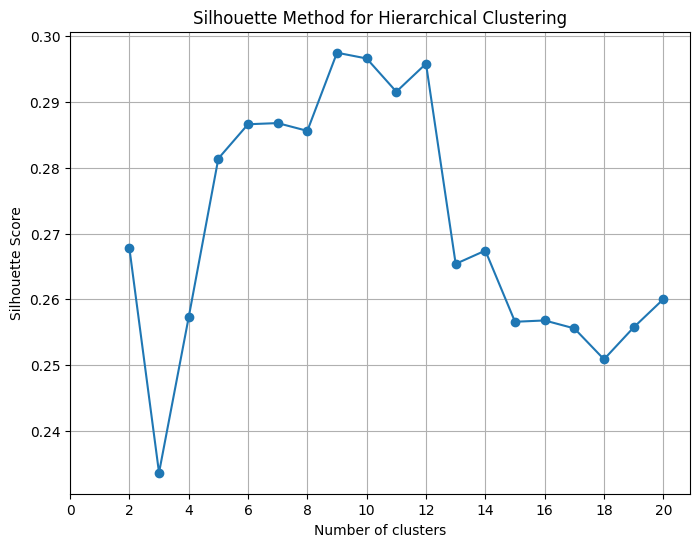

2 clusters: 16298.18948684559
3 clusters: 9908.790422652528
4 clusters: 6219.616931012908
5 clusters: 3945.2710298272095
6 clusters: 2359.878632178787
7 clusters: 1403.456418665143
8 clusters: 1294.051027293703
9 clusters: 995.2978317431599
10 clusters: 827.6018050392505
2 clusters: 0.2678047088845888
3 clusters: 0.2336665435185274
4 clusters: 0.2572767875464159
5 clusters: 0.28140167128513904
6 clusters: 0.28660648032228286
7 clusters: 0.28678359637785494
8 clusters: 0.2856020130357699
9 clusters: 0.29747393037557834
10 clusters: 0.29659787077224087

Clustering Method Comparison:

Method: KMeans
  Silhouette Score: 0.295
  Davies-Bouldin: 1.551
  Calinski-Harabasz: 42.474

Method: Agglomerative
  Silhouette Score: 0.297
  Davies-Bouldin: 1.538
  Calinski-Harabasz: 40.194

Method: Spectral
  Silhouette Score: 0.308
  Davies-Bouldin: 1.603
  Calinski-Harabasz: 33.307

Method: GMM
  Silhouette Score: 0.295
  Davies-Bouldin: 1.551
  Calinski-Harabasz: 42.474

Ranking by Metrics:

Metric: 

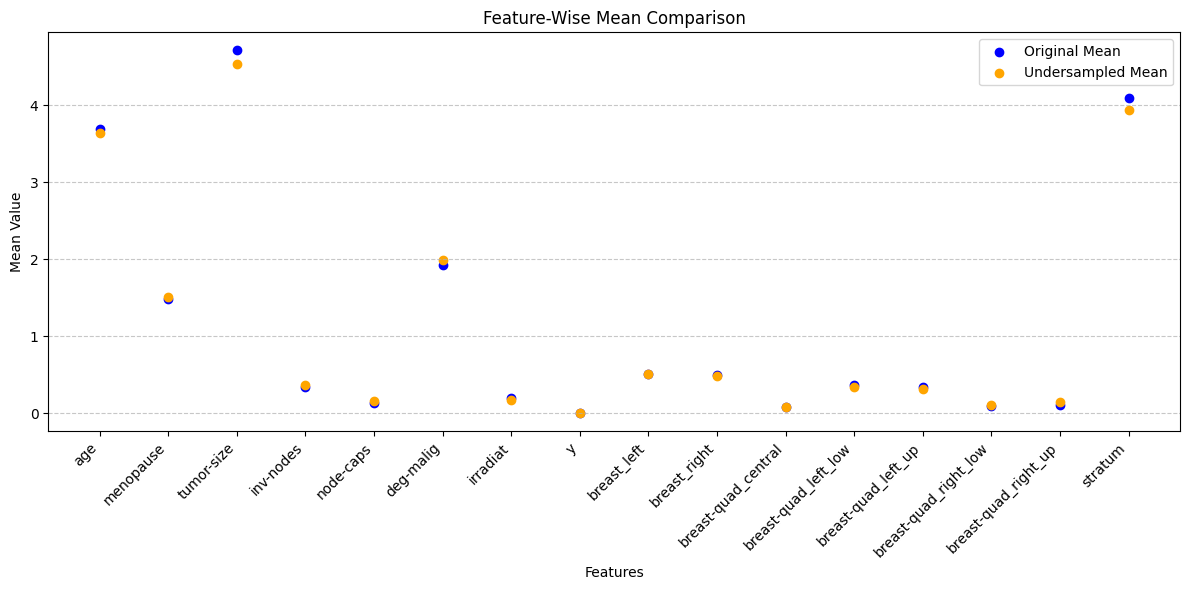

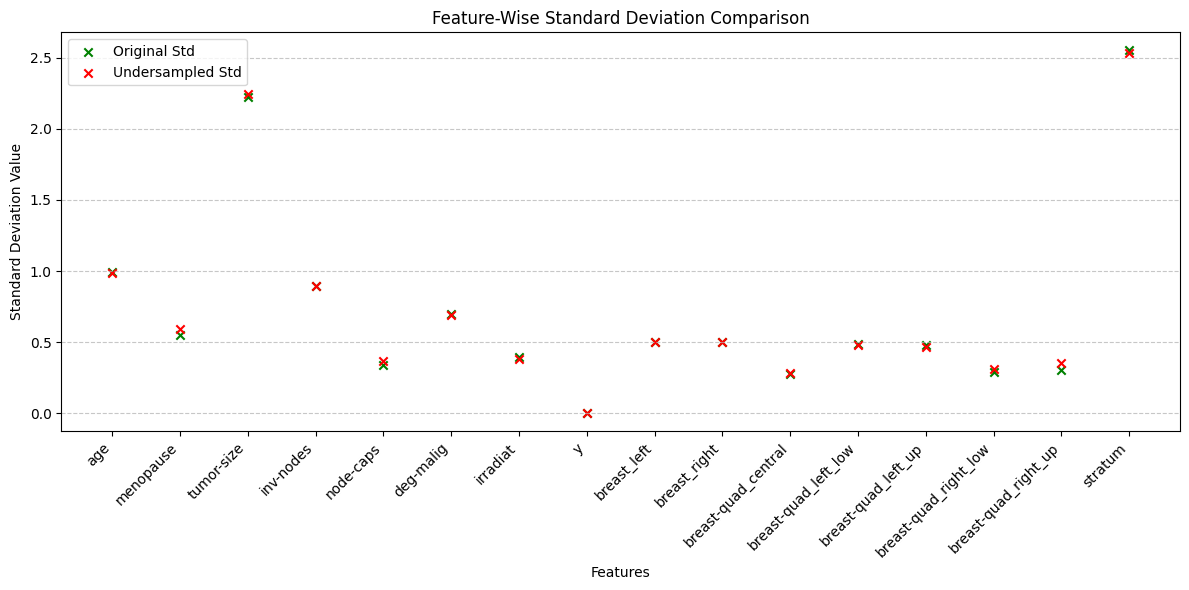

0    82
1    81
Name: y, dtype: int64


In [46]:
resampled_data=sampling(data)

In [ ]:
# resampled_data2=sampling(data2)

In [16]:
print("DONE!")
resampled_data

DONE!


,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,irradiat,y,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,3,2,6,0,0,1,1,1,1,0,0,1,0,0,0
1,4,2,5,1,1,3,1,1,1,0,0,1,0,0,0
2,2,2,8,0,0,1,0,1,1,0,0,0,1,0,0
3,1,2,7,0,0,2,0,0,0,1,0,0,0,0,1
4,3,1,4,0,0,2,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,4,2,4,1,1,2,0,0,1,0,0,1,0,0,0
159,3,2,6,5,1,3,0,1,1,0,0,1,0,0,0
160,4,1,8,0,0,3,0,0,1,0,0,0,0,0,1
161,3,2,6,0,0,3,0,1,0,1,0,0,0,0,1


Confusion Matrix:
[[3 4]
 [3 7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.64      0.70      0.67        10

    accuracy                           0.59        17
   macro avg       0.57      0.56      0.56        17
weighted avg       0.58      0.59      0.58        17



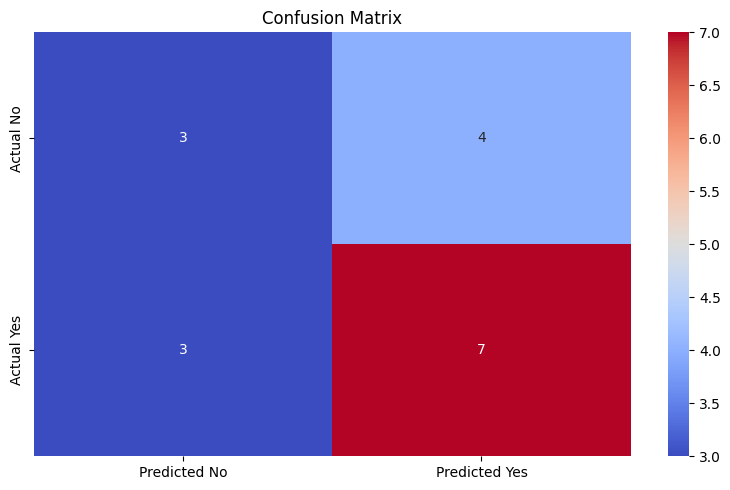

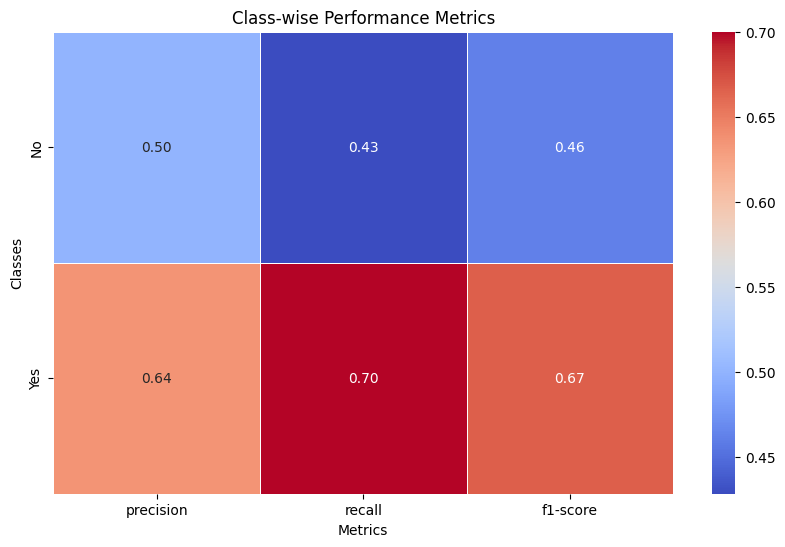

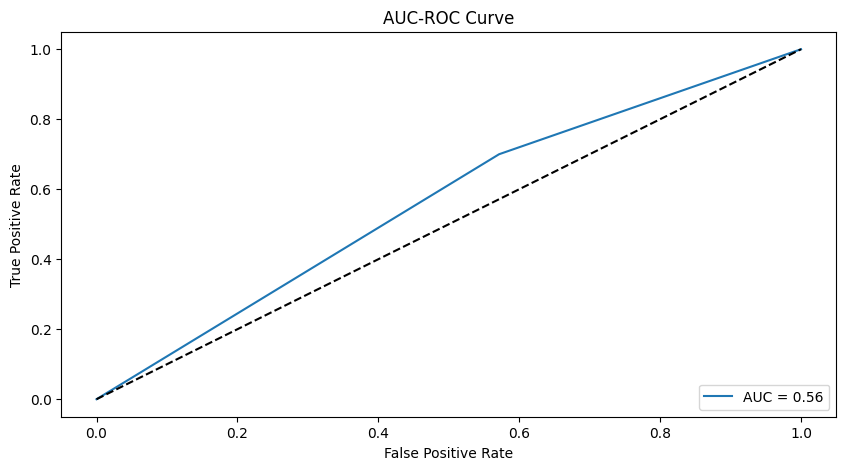

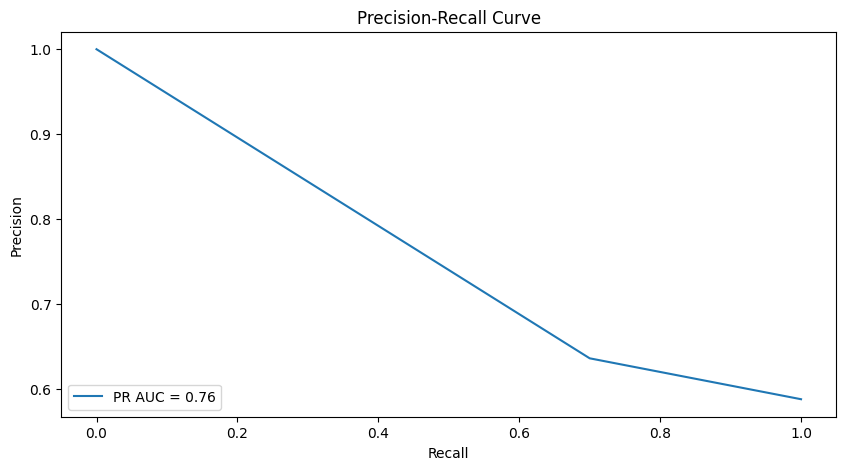

In [17]:
classification_and_evaluation(resampled_data)

Training Data shape (already undersampled): (130, 14), (130,)
Testing Data shape (already undersampled): (33, 14), (33,)


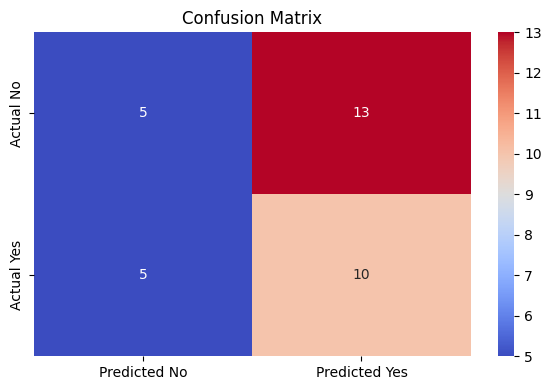

Confusion Matrix:
[[ 5 13]
 [ 5 10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.28      0.36        18
           1       0.43      0.67      0.53        15

    accuracy                           0.45        33
   macro avg       0.47      0.47      0.44        33
weighted avg       0.47      0.45      0.43        33



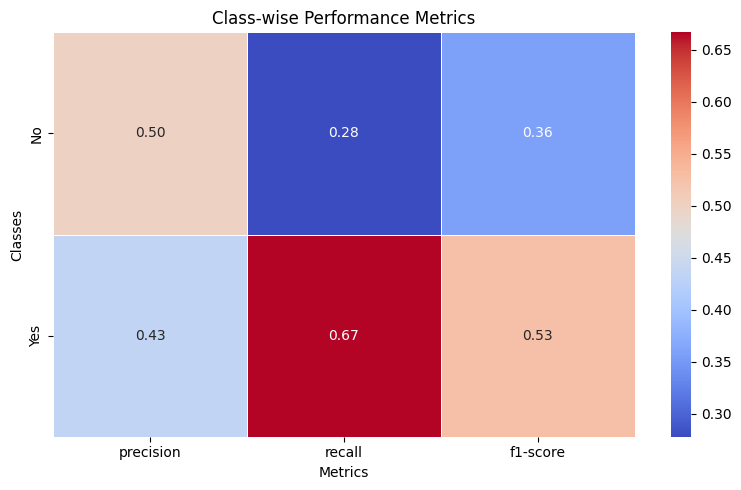

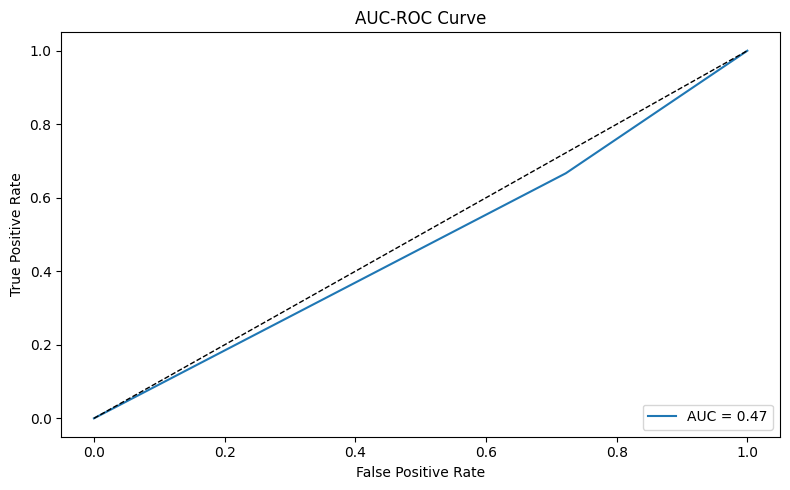

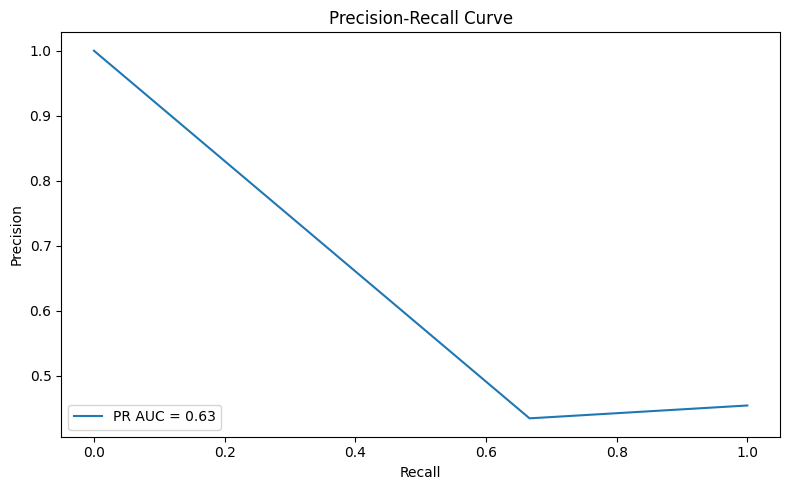

In [38]:
# baseline:

# classification_and_evaluation(data, baseline='R') # 129; 33
classification_and_evaluation(resampled_data) # (130, 14), (130,)

In [30]:
# # Create a pairwise MI matrix
# from sklearn.metrics import mutual_info_score
# from sklearn.cluster import AgglomerativeClustering, SpectralClustering
# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.spatial.distance import pdist
# # import numpy as np
# def sampling_through_mutual_information(df, num_strata_fixed, use_features, allocation, max_clusters=10):
#     """
#     Perform stratified undersampling with optional dynamic determination of the number of strata.

#     :param df: DataFrame with features and target 'y'.
#     :param num_strata_fixed: Boolean indicating whether the number of strata is fixed.
#     :param use_features: Flag to decide whether to use all features or mutual information for clustering.
#     :param allocation: Allocation type for undersampling (e.g., 'Neyman', 'Optimal', None).
#     :param max_clusters: Maximum number of clusters to test when finding optimal strata.
#     :return: Balanced DataFrame with undersampled majority class.
#     """
    

#     # Step 1: Filter majority class samples for MI calculation and stratification (OK)
#     majority_class = df[df['y'] == 0].copy()

#     # Step 2: Compute pairwise MI between majority class samples (OK)
#     X_majority = majority_class.drop(columns=['y']).values  # Features of majority class
#     N = len(X_majority)

#     mi_matrix = np.zeros((N, N))
#     for i in range(N):
#         for j in range(i, N):
#             mi = mutual_info_score(X_majority[i], X_majority[j])
#             mi_matrix[i, j] = mi
#             mi_matrix[j, i] = mi  # Symmetric matrix

    
#     # Step 3: Determine the number of strata (OK)
#     within_cluster_dissimilarity = elbow_method_for_clusters(mi_matrix)

#     # Print the dissimilarity values for each number of clusters
#     for n_clusters, dissim in zip(range(2, 11), within_cluster_dissimilarity):
#         print(f"{n_clusters} clusters: {dissim}")

#     optimal_num_strata = 4


#     # Step 4: Group majority class samples into strata using clustering on MI matrix

#     # clustering = AgglomerativeClustering(n_clusters=optimal_num_strata, metric='precomputed', linkage='average')
#     # majority_class['stratum'] = clustering.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

#     spectral = SpectralClustering(n_clusters=optimal_num_strata, affinity='precomputed', random_state=42)
#     majority_class['stratum'] = spectral.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

#     print(majority_class['stratum'].value_counts())

#     # Step 5: Perform undersampling on majority class samples
#     # Total number of samples to be sampled from the majority class (equal to the minority class size)
#     minority_class_size = len(df[df['y'] == 1])

#     # Group majority class by stratum
#     strata_groups = majority_class.groupby('stratum')

#     # Initial Equal Allocation: Sample the same number of samples from each stratum
#     samples_per_stratum = minority_class_size // len(strata_groups)
#     remaining_samples = minority_class_size - (samples_per_stratum * len(strata_groups))

#     sampled_strata = []

#     # Perform initial SRS on each stratum with equal allocation
#     for stratum, group in strata_groups:
#         num_samples_to_sample = min(samples_per_stratum, len(group))  # Ensure we don't sample more than available
#         sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
#         sampled_strata.append(sampled_group)

#     # Keep track of the number of samples we have so far
#     sampled_majority_class = pd.concat(sampled_strata, axis=0)
#     remaining_samples_needed = minority_class_size - len(sampled_majority_class)

#     # If there are remaining samples to be drawn, perform SRS again
#     while remaining_samples_needed > 0:
#         print(f"Remaining samples needed: {remaining_samples_needed}")

#         # Find strata that still have samples left to be drawn
#         remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]

#         # Sample from these remaining strata using SRS
#         strata_groups_remaining = remaining_strata.groupby('stratum')

#         for stratum, group in strata_groups_remaining:
#             # If there are still remaining samples in this stratum, sample them
#             num_samples_to_sample = min(len(group), remaining_samples_needed)
#             sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
#             sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
            
#             # Reduce remaining samples needed
#             remaining_samples_needed -= num_samples_to_sample
            
#             # Exit early if no more samples are needed
#             if remaining_samples_needed <= 0:
#                 break


#     # Step 6: Combine undersampled majority class with the minority class

#     minority_class = df[df['y'] == 1]  # Keep all minority class samples

#     final_df = pd.concat([sampled_majority_class, minority_class])

#     # Shuffle the resulting dataset
#     final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

#     # Drop unneeded columns
#     final_df.drop(columns=['stratum'], inplace=True)

#     print(final_df['y'].value_counts())

#     return final_df

In [107]:
# # Create a pairwise MI matrix
# from sklearn.metrics import mutual_info_score
# from sklearn.cluster import AgglomerativeClustering, SpectralClustering
# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.spatial.distance import pdist
# from sklearn.manifold import MDS
# # import numpy as np
# def sampling_through_mutual_information2(df, num_strata_fixed, use_features, allocation, max_clusters=10):
#     """
#     Perform stratified undersampling with optional dynamic determination of the number of strata.

#     :param df: DataFrame with features and target 'y'.
#     :param num_strata_fixed: Boolean indicating whether the number of strata is fixed.
#     :param use_features: Flag to decide whether to use all features or mutual information for clustering.
#     :param allocation: Allocation type for undersampling (e.g., 'Neyman', 'Optimal', None).
#     :param max_clusters: Maximum number of clusters to test when finding optimal strata.
#     :return: Balanced DataFrame with undersampled majority class.
#     """
    

#     # Step 1: Filter majority class samples for MI calculation and stratification (OK)
#     majority_class = df[df['y'] == 0].copy()

#     # Step 2: Compute pairwise MI between majority class samples (OK)
#     X_majority = majority_class.drop(columns=['y']).values  # Features of majority class
#     N = len(X_majority)

#     mi_matrix = np.zeros((N, N))
#     for i in range(N):
#         for j in range(i, N):
#             mi = mutual_info_score(X_majority[i], X_majority[j])
#             mi_matrix[i, j] = mi
#             mi_matrix[j, i] = mi  # Symmetric matrix


#     print("STEP 3:")
#     # Step 3: Determine the number of strata (infer from elbow method)
#     # Now call the function with your MI matrix
#     # MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
#     within_cluster_dissimilarity = elbow_method_for_clusters(mi_matrix)

#     # Optionally, print the dissimilarity values for each number of clusters
#     for n_clusters, dissim in zip(range(2, 11), within_cluster_dissimilarity):
#         print(f"{n_clusters} clusters: {dissim}")
#     optimal_num_strata = 4


#     # Step 4: Group majority class samples into strata using clustering on MI matrix

#     # hierarchial clustering (POOR)
#     # clustering = AgglomerativeClustering(n_clusters=optimal_num_strata, metric='precomputed', linkage='average')
#     # majority_class['stratum'] = clustering.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

#     # Spectral clustering (SLIGHTLY BETTER)
#     # spectral = SpectralClustering(n_clusters=optimal_num_strata, affinity='precomputed', random_state=42)
#     # majority_class['stratum'] = spectral.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

#     # K-means clustering
#     distance_matrix = 1 - mi_matrix
#     mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
#     X_mds = mds.fit_transform(distance_matrix)
#     kmeans = KMeans(n_clusters=optimal_num_strata, random_state=42)
#     majority_class['stratum'] = kmeans.fit_predict(X_mds)

#     print(majority_class['stratum'].value_counts())

#     # Step 5: Perform undersampling on majority class samples

#     # Group majority class by stratum
#     strata_groups = majority_class.groupby('stratum')
#     minority_class_size = len(df[df['y'] == 1])
#     allocation='Optimal'
#     # Select allocation method
#     if allocation == 'Equal':
#         sampled_majority_class = equal_allocation(majority_class, strata_groups, minority_class_size)
#     elif allocation == 'Neyman':
#         sampled_majority_class = neyman_allocation(majority_class, strata_groups, minority_class_size)
#     elif allocation == 'Optimal':
#         sampled_majority_class = optimal_allocation(majority_class, strata_groups, minority_class_size)
    

#     # Step 6: Combine undersampled majority class with the minority class
#     minority_class = df[df['y'] == 1]  # Keep all minority class samples
#     final_df = pd.concat([sampled_majority_class, minority_class])

#     # Shuffle the resulting dataset
#     final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

#     # Drop unneeded columns
#     final_df.drop(columns=['stratum'], inplace=True)

#     print(final_df['y'].value_counts())

#     return final_df